In [2]:
import sys
import os
import json
import numpy as np
import pandas as pd
from importlib import import_module
import matplotlib.pyplot as plt
from types import MethodType

from sklearn.preprocessing import StandardScaler
import torch

# Add the parent directory to the Python path
sys.path.append(os.path.abspath('..')) # if this script is in a subdirectory

# Load TVAE modules
from tvae.tvae_wrapper import TVAESynthesizer, LossValuesMixin
from tvae.data_loader import load_csvs

# Load SDV modules
from sdv.metadata import Metadata, SingleTableMetadata
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality

# test
from latent_space_rhc import (
    visualize_latent_space_rhc,
    compare_original_synthetic_latent_rhc,
    save_latent_space
)

In [3]:
datasets = load_csvs(folder_name='/home/mfacotti/martin/tVAE_Synthesis/data')

# load data
rhc_data = datasets['rhc']

# Display basic information about the loaded data
print(f"Dataset shape: {rhc_data.shape}")

Dataset shape: (5735, 62)


/home/mfacotti/martin/tVAE_Synth/tvae/data_loader.py:36: UserWarning:

Ignoring incompatible files ['metadata.json'] in folder '/home/mfacotti/martin/tVAE_Synthesis/data'.



In [4]:
metadata = SingleTableMetadata()
metadata = Metadata.load_from_json('../data/metadata.json')
metadata.validate()

In [5]:
model = TVAESynthesizer(
        metadata,
        embedding_dim=32, # latent space dimensions
        compress_dims=(128, 32), # encoder dimensions
        decompress_dims=(32, 128), # decoder dimensions
        l2scale=1e-5,
        batch_size=256,
        verbose=True,
        epochs=500,
        loss_factor=2,
)

model.fit(rhc_data)

Loss: 43.219: 100%|██████████| 500/500 [13:30<00:00,  1.62s/it]


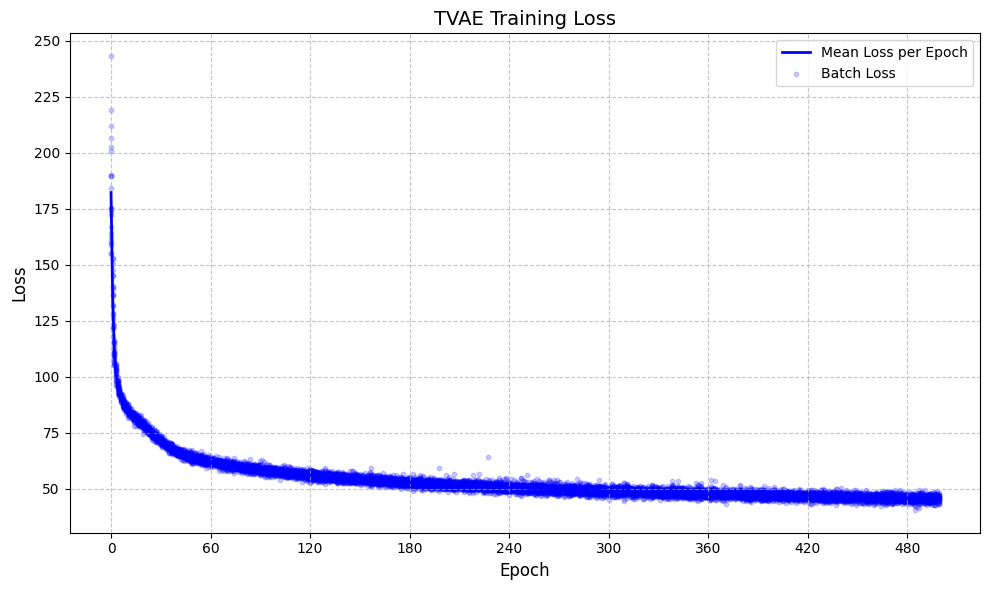

In [6]:
model.plot_loss(show_batch_loss=True);  # Note the semicolon

In [9]:
model_name = 'tvae_ep500_compress32'
model_filepath = f'test_model_{model_name}.pkl'

In [13]:
model.save(
    filepath=model_filepath
)

In [10]:
synthetic_data = model.sample(len(rhc_data))

In [15]:
output_filename = f'synthetic_data_{model_name}.csv'
synthetic_data.to_csv(output_filename, index=False)

In [9]:
synthetic_data = pd.read_csv('synthetic_data_tvae_ep1000_compress32.csv')


In [51]:
diagnostic = run_diagnostic(
    real_data=rhc_data,
    synthetic_data=synthetic_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 62/62 [00:00<00:00, 587.83it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 227.95it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [52]:
quality_report = evaluate_quality(
    rhc_data,
    synthetic_data,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 62/62 [00:03<00:00, 18.15it/s]|
Column Shapes Score: 87.07%

(2/2) Evaluating Column Pair Trends: |██████████| 1891/1891 [00:18<00:00, 103.87it/s]|
Column Pair Trends Score: 77.98%

Overall Score (Average): 82.52%

